In [0]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [2]:
dataset, info = tfds.load("imdb_reviews/subwords8k", with_info=True,
                          as_supervised = True)
train, test = dataset['train'], dataset['test']

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteRK81QD/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteRK81QD/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteRK81QD/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


**Visualizing Dataset** This dataset is encoded using subword encoder so we have to decode each tensor using the encoder object to view it in text

In [0]:
encoder = info.features['text'].encoder

In [40]:
for x in train.take(5):
    print(f"Text: {encoder.decode(x[0].numpy())}")
    print(f"Sentiment: {('negative', 'positive')[x[1].numpy()]}", end='\n\n')

Text: This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.
Sentiment: negative

Text: I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbi

In [0]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64
EPOCHS = 10

**Preparing Dataset** We use padding to make each data point of equal size.

In [0]:
train_ds = (train
            .shuffle(BUFFER_SIZE)
            .padded_batch(BATCH_SIZE, padded_shapes=([None], [])))
test_ds = (test
           .padded_batch(BATCH_SIZE, padded_shapes=([None], [])))

**Training and Testing a sample model**

In [0]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(input_dim = encoder.vocab_size,output_dim = 64))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)))
model.add(tf.keras.layers.Dense(64, activation="relu"))
model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          523840    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 598,209
Trainable params: 598,209
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics = ["accuracy"])

In [15]:
history = model.fit(train_ds, epochs=EPOCHS,
                    validation_data = test_ds)

Epoch 1/10
391/391 [==============================] - 60s 153ms/step - loss: 0.6673 - accuracy: 0.5852 - val_loss: 0.6441 - val_accuracy: 0.6940
Epoch 2/10
391/391 [==============================] - 60s 152ms/step - loss: 0.6273 - accuracy: 0.7183 - val_loss: 0.6371 - val_accuracy: 0.7048
Epoch 3/10
391/391 [==============================] - 60s 153ms/step - loss: 0.6235 - accuracy: 0.7309 - val_loss: 0.6467 - val_accuracy: 0.6382
Epoch 4/10
391/391 [==============================] - 60s 153ms/step - loss: 0.6182 - accuracy: 0.7323 - val_loss: 0.6351 - val_accuracy: 0.6904
Epoch 5/10
391/391 [==============================] - 60s 153ms/step - loss: 0.6100 - accuracy: 0.7534 - val_loss: 0.6342 - val_accuracy: 0.6878
Epoch 6/10
391/391 [==============================] - 60s 154ms/step - loss: 0.6065 - accuracy: 0.7667 - val_loss: 0.6381 - val_accuracy: 0.7341
Epoch 7/10
391/391 [==============================] - 60s 154ms/step - loss: 0.6208 - accuracy: 0.7244 - val_loss: 0.6931 - val_ac

Function for plotting graphs

In [0]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.grid(True)
    plt.show()

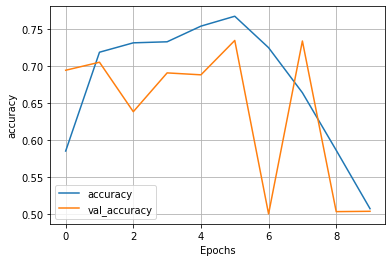

In [31]:
plot_graphs(history, 'accuracy')

**Comparision of SimpleRNN vs LSTM vs GRU models.** 
Keeping other things same in the model. This model is basic with no regularization or dropout

In [0]:
def sentiment_model(input_shape, rnn_layer_type = "LSTM"):
    """
    RNN based model for sentient prediction.

    Args:
    input_shape: input shape for the encoder layer. It is basically your vocabulary size
    rnn_layer_type: Type of the rnn layer to use. One of [`LSTM`, `RNN`, `GRU`]

    Returns:
    Uncompiled Keras model

    """
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Embedding(input_shape, output_dim = 64))
    rnn = None
    if rnn_layer_type == "RNN":
        rnn = tf.keras.layers.SimpleRNN(64)
    elif rnn_layer_type == "LSTM":
        rnn = tf.keras.layers.LSTM(64)
    elif rnn_layer_type == "GRU":
        rnn = tf.keras.layers.GRU(64)
    else:
        print("Enter valid rnn_layer_type: One of [`LSTM`, `RNN`, `GRU`]")
        return None
    model.add(tf.keras.layers.Bidirectional(rnn))
    model.add(tf.keras.layers.Dense(64, activation="relu"))
    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))
    return model

In [37]:
rnn_model = sentiment_model(encoder.vocab_size, rnn_layer_type="RNN")
rnn_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                  optimizer = tf.keras.optimizers.Adam(1e-4),
                  metrics = ["accuracy"]
                  )
rnn_history = rnn_model.fit(train_ds, epochs = EPOCHS,
                            validation_data = test_ds)

Epoch 1/10
391/391 [==============================] - 752s 2s/step - loss: 0.6511 - accuracy: 0.6012 - val_loss: 0.5983 - val_accuracy: 0.6788
Epoch 2/10
391/391 [==============================] - 767s 2s/step - loss: 0.4252 - accuracy: 0.8145 - val_loss: 0.4065 - val_accuracy: 0.8344
Epoch 3/10
391/391 [==============================] - 789s 2s/step - loss: 0.2813 - accuracy: 0.8916 - val_loss: 0.3703 - val_accuracy: 0.8504
Epoch 4/10
391/391 [==============================] - 785s 2s/step - loss: 0.2322 - accuracy: 0.9146 - val_loss: 0.3862 - val_accuracy: 0.8462
Epoch 5/10
391/391 [==============================] - 769s 2s/step - loss: 0.1764 - accuracy: 0.9404 - val_loss: 0.4063 - val_accuracy: 0.8556
Epoch 6/10
391/391 [==============================] - 748s 2s/step - loss: 0.1367 - accuracy: 0.9560 - val_loss: 0.4476 - val_accuracy: 0.8272
Epoch 7/10
391/391 [==============================] - 747s 2s/step - loss: 0.1047 - accuracy: 0.9662 - val_loss: 0.4899 - val_accuracy: 0.8500

In [41]:
rnn_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, None, 64)          523840    
_________________________________________________________________
bidirectional_7 (Bidirection (None, 128)               16512     
_________________________________________________________________
dense_20 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_21 (Dense)             (None, 8)                 520       
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 9         
Total params: 549,137
Trainable params: 549,137
Non-trainable params: 0
_________________________________________________________________


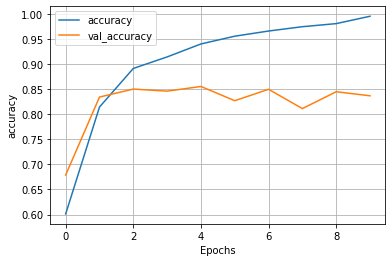

In [38]:
plot_graphs(rnn_history, 'accuracy')

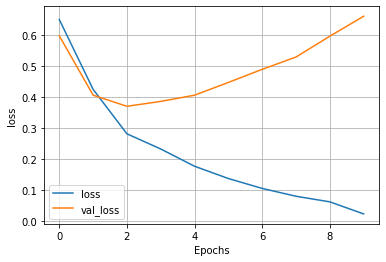

In [39]:
plot_graphs(rnn_history, 'loss')

In [27]:
lstm_model = sentiment_model(encoder.vocab_size, rnn_layer_type="LSTM")
lstm_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                  optimizer = tf.keras.optimizers.Adam(1e-4),
                  metrics = ["accuracy"]
                  )
lstm_history = lstm_model.fit(train_ds, epochs=EPOCHS,
                              validation_data = test_ds)

Epoch 1/10
391/391 [==============================] - 61s 157ms/step - loss: 0.6767 - accuracy: 0.5797 - val_loss: 0.6041 - val_accuracy: 0.7118
Epoch 2/10
391/391 [==============================] - 61s 155ms/step - loss: 0.4056 - accuracy: 0.8290 - val_loss: 0.3580 - val_accuracy: 0.8521
Epoch 3/10
391/391 [==============================] - 62s 157ms/step - loss: 0.2718 - accuracy: 0.8959 - val_loss: 0.3401 - val_accuracy: 0.8700
Epoch 4/10
391/391 [==============================] - 61s 155ms/step - loss: 0.2269 - accuracy: 0.9186 - val_loss: 0.3265 - val_accuracy: 0.8659
Epoch 5/10
391/391 [==============================] - 60s 155ms/step - loss: 0.1899 - accuracy: 0.9346 - val_loss: 0.3424 - val_accuracy: 0.8680
Epoch 6/10
391/391 [==============================] - 61s 156ms/step - loss: 0.2017 - accuracy: 0.9257 - val_loss: 0.3561 - val_accuracy: 0.8659
Epoch 7/10
391/391 [==============================] - 59s 152ms/step - loss: 0.1555 - accuracy: 0.9477 - val_loss: 0.3989 - val_ac

In [42]:
lstm_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 64)          523840    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 128)               66048     
_________________________________________________________________
dense_14 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_15 (Dense)             (None, 8)                 520       
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 9         
Total params: 598,673
Trainable params: 598,673
Non-trainable params: 0
_________________________________________________________________


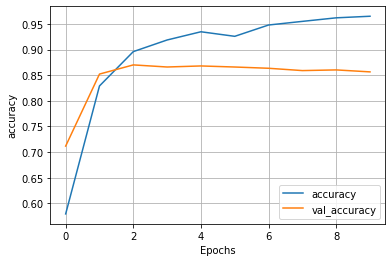

In [32]:
plot_graphs(lstm_history, 'accuracy')

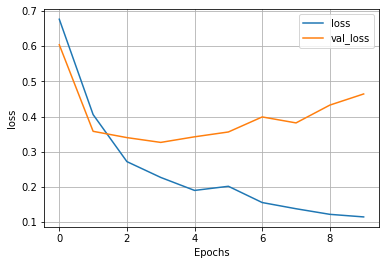

In [33]:
plot_graphs(lstm_history, 'loss')

In [34]:
gru_model = sentiment_model(encoder.vocab_size, rnn_layer_type="GRU")
gru_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                  optimizer = tf.keras.optimizers.Adam(1e-4),
                  metrics = ["accuracy"]
                  )
gru_history = gru_model.fit(train_ds, epochs=EPOCHS,
                            validation_data = test_ds)

Epoch 1/10
391/391 [==============================] - 59s 152ms/step - loss: 0.6924 - accuracy: 0.5215 - val_loss: 0.6904 - val_accuracy: 0.5295
Epoch 2/10
391/391 [==============================] - 58s 148ms/step - loss: 0.5329 - accuracy: 0.7236 - val_loss: 0.3759 - val_accuracy: 0.8398
Epoch 3/10
391/391 [==============================] - 58s 147ms/step - loss: 0.2938 - accuracy: 0.8838 - val_loss: 0.3469 - val_accuracy: 0.8598
Epoch 4/10
391/391 [==============================] - 59s 151ms/step - loss: 0.2235 - accuracy: 0.9174 - val_loss: 0.3381 - val_accuracy: 0.8598
Epoch 5/10
391/391 [==============================] - 58s 148ms/step - loss: 0.1923 - accuracy: 0.9317 - val_loss: 0.3701 - val_accuracy: 0.8542
Epoch 6/10
391/391 [==============================] - 58s 148ms/step - loss: 0.1664 - accuracy: 0.9421 - val_loss: 0.3948 - val_accuracy: 0.8642
Epoch 7/10
391/391 [==============================] - 58s 148ms/step - loss: 0.1473 - accuracy: 0.9520 - val_loss: 0.4146 - val_ac

In [43]:
gru_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 64)          523840    
_________________________________________________________________
bidirectional_6 (Bidirection (None, 128)               49920     
_________________________________________________________________
dense_17 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_18 (Dense)             (None, 8)                 520       
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 9         
Total params: 582,545
Trainable params: 582,545
Non-trainable params: 0
_________________________________________________________________


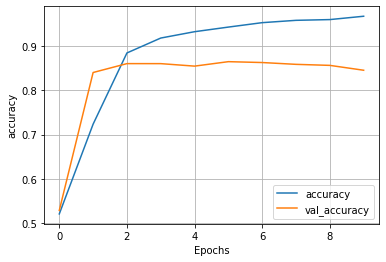

In [35]:
plot_graphs(gru_history, 'accuracy')

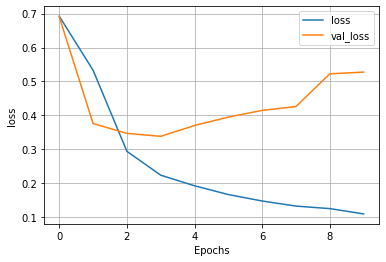

In [36]:
plot_graphs(gru_history, 'loss')